## 利用pytorch搭建一个LeNet模型  模型如下图所示

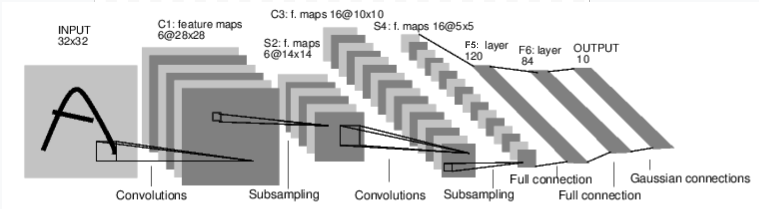

## 首先导入搭建LeNet要用到的库

In [54]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

## 主要用到nn.conv2d构建卷积层，nn.MaxPool2d构建池化层，nn.Linear构建全连接层。具体用法可以查看官方文档https://pytorch.org/docs/stable/index.html

In [9]:
class LeNet(nn.Module):                     # 继承于nn.Module这个父类
    def __init__(self):                     # 初始化网络结构
        super(LeNet, self).__init__()       # 多继承需用到super函数
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):			 # 正向传播过程
        x = F.relu(self.conv1(x))    # input(3, 32, 32) output(16, 28, 28)
        x = self.pool1(x)            # output(16, 14, 14)
        x = F.relu(self.conv2(x))    # output(32, 10, 10)
        x = self.pool2(x)            # output(32, 5, 5)
        x = x.view(-1, 32*5*5)       # output(32*5*5)
        x = F.relu(self.fc1(x))      # output(120)
        x = F.relu(self.fc2(x))      # output(84)
        x = self.fc3(x)              # output(10)
        return x

## 利用torchvision下载数据集，并对数据集进行预处理。此demo用的是CIFAR10数据集，共包含 10 类 RGB 彩色图片。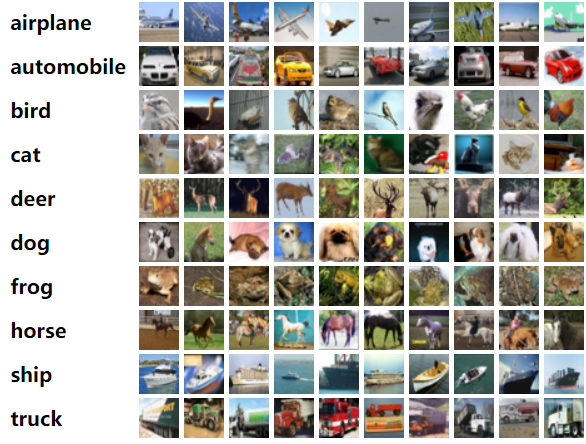

In [56]:
transform = transforms.Compose( [transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# 导入50000张训练图片
train_set = torchvision.datasets.CIFAR10(root='./data',      # 数据集存放目录
                                        train=True,          # 表示是数据集中的训练集
                                        download=False,       # 第一次运行时为True，下载数据集，下载完成后改为False
                                        transform=transform) # 预处理过程
# 加载训练集，实际过程需要分批次（batch）训练                                        
train_loader = torch.utils.data.DataLoader(train_set,     # 导入的训练集
                                          batch_size=50,  # 每批训练的样本数
                                          shuffle=True,  # 是否打乱训练集
                                          num_workers=0)  # 使用线程数，在windows下设置为0
# 导入10000张测试图片
test_set = torchvision.datasets.CIFAR10(root='./data', 
                                        train=False,     # 表示是数据集中的测试集
                                        download=False,
                                        transform=transform)
# 加载测试集
test_loader = torch.utils.data.DataLoader(test_set, 
                                          batch_size=10000, # 每批用于验证的样本数
                                          shuffle=False, num_workers=0)
# 获取测试集中的图像和标签，用于后续accuracy计算
test_data_iter = iter(test_loader)
test_image, test_label = test_data_iter.next()

## 展示一些训练图像示例

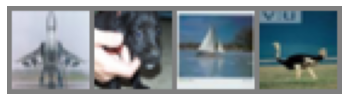

plane   dog  ship  bird


In [57]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

dataiter = iter(train_loader)
images,labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 网络训练，完成后保存模型

In [78]:
net = LeNet()                                       # 定义训练的网络模型
loss_function = nn.CrossEntropyLoss()               # 定义损失函数为交叉熵损失函数 
optimizer = optim.Adam(net.parameters(), lr=0.001)  # 定义优化器（训练参数，学习率）

for epoch in range(5):                              # 一个epoch即对整个训练集进行一次训练
    running_loss = 0.0
    time_start = time.perf_counter()

    for step, data in enumerate(train_loader, start=0):   # 遍历训练集，step从0开始计算
        inputs, labels = data                             # 获取训练集的图像和标签
        optimizer.zero_grad()                             # 清除历史梯度
        
        # forward + backward + optimize
        outputs = net(inputs)                             # 正向传播
        loss = loss_function(outputs, labels)             # 计算损失
        loss.backward()                                   # 反向传播
        optimizer.step()                                  # 优化器更新参数

        # 打印耗时、损失、准确率等数据
        running_loss += loss.item()
        if step % 500 == 499:                            # print every 1000 mini-batches，每1000步打印一次
            with torch.no_grad():                         # 在以下步骤中（验证过程中）不用计算每个节点的损失梯度，防止内存占用
                outputs = net(test_image)                 # 测试集传入网络（test_batch_size=10000），output维度为[10000,10]
                predict_y = torch.max(outputs, dim=1)[1]  # 以output中值最大位置对应的索引（标签）作为预测输出
                accuracy = (predict_y == test_label).sum().item() / test_label.size(0)
                
                print('[%d, %5d] train_loss: %.3f  test_accuracy: %.3f' %  # 打印epoch，step，loss，accuracy
                      (epoch + 1, step + 1, running_loss / 500, accuracy))
                
                print('%f s' % (time.perf_counter() - time_start))        # 打印耗时
                running_loss = 0.0

print('Finished Training')

# 保存训练得到的参数
save_path = './LeNet.pth'
torch.save(net,save_path)

[1,   500] train_loss: 1.664  test_accuracy: 0.481
7.781254 s
[1,  1000] train_loss: 1.368  test_accuracy: 0.536
15.672480 s
[2,   500] train_loss: 1.231  test_accuracy: 0.579
7.923246 s
[2,  1000] train_loss: 1.132  test_accuracy: 0.594
15.826946 s
[3,   500] train_loss: 1.049  test_accuracy: 0.617
7.974314 s
[3,  1000] train_loss: 1.013  test_accuracy: 0.642
15.866998 s
[4,   500] train_loss: 0.927  test_accuracy: 0.647
7.868054 s
[4,  1000] train_loss: 0.925  test_accuracy: 0.662
15.874143 s
[5,   500] train_loss: 0.842  test_accuracy: 0.675
7.869923 s
[5,  1000] train_loss: 0.859  test_accuracy: 0.670
15.943379 s
Finished Training


## 利用训练好的网络对图片进行预测

In [134]:
from PIL import Image

In [133]:
model=torch.load(save_path)
img_path = '1.jpg'
img_data = np.array(Image.open(img_path).resize((32,32)))
img_data =transform(img_data)
img_data = torch.unsqueeze(img_data,dim=0)
out = model(img_data)
label = out.data.max(1,keepdims=True)[1]
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print("the category is :"+classes[label])

the category is :bird
